In [1]:
"""
2018 09 07 Lecture

@author: nhjeong & wilee
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model, model_from_json
from keras.layers import Activation, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, BatchNormalization, Add
from keras.optimizers import Adam
import h5py
import scipy.io as sio
from keras import backend as K

Using TensorFlow backend.


In [2]:
N = 44000

X_mat = h5py.File('database/db.mat')
X_input = X_mat['db']
X_train = X_input[0:N, ]
X_val = X_input[N:, ]

Y_mat = h5py.File('database/gt.mat')
Y_input = Y_mat['gt']
Y_train = Y_input[0:N, ]
Y_val = Y_input[N:, ]

X_mat_test = h5py.File('database/test_db.mat')
X_input_test = X_mat_test['test_db']
X_test = X_input_test[0:, ]

Y_mat_test = h5py.File('database/test_gt.mat')
Y_input_test = Y_mat_test['test_gt']
Y_test = Y_input_test[0:, ]


X_mat.close()
Y_mat.close()
X_mat_test.close()
Y_mat_test.close()

First let's define the two different types of layers that we will be using.

In [3]:
def down(input_layer, filters, pool=True):
    conv = Conv2D(filters, (3, 3), padding='same')(input_layer)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    residual = Conv2D(filters, (3, 3), padding='same')(conv)
    residual = BatchNormalization()(residual)
    residual = Activation('relu')(residual)

    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

In [4]:
def up(input_layer, residual, filters):
    filters = int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])

    conv1 = Conv2D(filters, (3, 3), padding='same')(concat)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    return conv2

In [5]:
def up_fcn1(input_layer, filters):
   filters = int(filters)
   upsample = UpSampling2D()(input_layer)
   upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)

   conv1 = Conv2D(filters, (3, 3), padding='same')(upconv)
   conv1 = BatchNormalization()(conv1)
   conv1 = Activation('relu')(conv1)
   return conv1


#def up_fcn2(input_layer, filters):
#    filters = int(filters)
#    upsample = Conv2DTranspose(filters, (3, 3), padding='same',strides=(2,2))(input_layer)
#    return upsample

In [6]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

Now let's use Tensorflow to write our own dice_coefficient metric

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5

    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))

    isct = tf.reduce_sum(y_true * y_pred)

    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [8]:
def make_unet_model():
    # Make a custom U-nets implementation.
    filters = 32
    #input_layer = Input(shape=[256, 256, 1])
    input_layer = Input(shape=[64, 64, 1])
    layers = [input_layer]
    residuals = []

    # Down 1, 128
    d1, res1 = down(input_layer, filters)
    residuals.append(res1)

    filters *= 2

    # Down 2, 64
    d2, res2 = down(d1, filters)
    residuals.append(res2)

    filters *= 2

    # Down 3, 32
    d3, res3 = down(d2, filters)
    residuals.append(res3)

    filters *= 2

    # Down 4, 16
    d4, res4 = down(d3, filters)
    residuals.append(res4)

    filters *= 2

    # Down 5, 8
    d5 = down(d4, filters, pool=False)

    # Up 1, 16
    up1 = up(d5, residual=residuals[-1], filters=filters / 2)

    filters /= 2

    # Up 2,  32
    up2 = up(up1, residual=residuals[-2], filters=filters / 2)

    filters /= 2

    # Up 3, 64
    up3 = up(up2, residual=residuals[-3], filters=filters / 2)

    filters /= 2

    # Up 4, 128
    up4 = up(up3, residual=residuals[-4], filters=filters / 2)

    fc1 = Conv2D(filters=32, kernel_size=(1, 1), activation="relu")(up4)

    out = Conv2D(filters=2, kernel_size=(1, 1), activation="softmax")(fc1)

    model = Model(input_layer, out)
    
    return model

In [9]:
def make_fcn_models():
    # Make a custom U-nets implementation.
    filters = 32
    #input_layer = Input(shape=[256, 256, 1])
    input_layer = Input(shape=[64, 64, 1])
    layers = [input_layer]
    residuals = []

    # Down 1, 128
    d1, res1 = down(input_layer, filters)
    residuals.append(res1)

    filters *= 2

    # Down 2, 64
    d2, res2 = down(d1, filters)
    residuals.append(res2)

    filters *= 2

    # Down 3, 32
    d3, res3 = down(d2, filters)
    residuals.append(res3)

    filters *= 2

    # Down 4, 16
    d4, res4 = down(d3, filters)
    residuals.append(res4)

    filters *= 2

    # Down 5, 8
    d5 = down(d4, filters, pool=False)
    
    # Up 1, 16
    up1 = up_fcn1(d5, filters=filters / 2)
    up1 = Add()([up1, residuals[-1]])
        
    filters /= 2

    # Up 2,  32
    up2 = up_fcn1(up1, filters=filters / 2)
    up2 = Add()([up2, residuals[-2]])
    
    models = {}

    fcn16s = UpSampling2D(size=(16, 16))(d5)
    fcn16s_out = Conv2D(filters=2, kernel_size=(1, 1), activation="softmax")(fcn16s)
    models['fcn16s'] = Model(input_layer, fcn16s_out)
    
    fcn8s = UpSampling2D(size=(8, 8))(up1)
    fcn8s_out = Conv2D(filters=2, kernel_size=(1, 1), activation="softmax")(fcn8s)
    models['fcn8s'] = Model(input_layer, fcn8s_out)
    
    fcn4s = UpSampling2D(size=(4, 4))(up2)
    fcn4s_out = Conv2D(filters=2, kernel_size=(1, 1), activation="softmax")(fcn4s)
    models['fcn4s'] = Model(input_layer, fcn4s_out)
    
    return models

In [10]:
def train(model):
    model.compile(optimizer=Adam(1e-4), loss=weighted_categorical_crossentropy([1.0, 7.0]), metrics=[dice_coef])
    hist = model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_val, Y_val))
    return hist

# Saving model
def save_model(model, model_name):
    model_json = model.to_json()
    with open(model_name + '.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(model_name + '.h5')
    print('Saved model to disk, {}'.format(model_name))
    
#Loading model
def load_model(model_name):
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_name + '.h5')
    print('Loaded model from disk, {}'.format(model_name))
    return loaded_model    

In [11]:
unet_model = make_unet_model()
models = make_fcn_models()
models['unet'] = unet_model

In [12]:
history = {}
for name, model in models.items():
    print(name + ' model')
    model.summary()
    history[name] = train(model)
    save_model(model, name)

fcn16s model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_19 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 64, 64, 32)        0       

Train on 44000 samples, validate on 8037 samples
Epoch 1/10
44000/44000 [==============================] - 44s 1ms/step - loss: 0.0746 - dice_coef: 0.9770 - val_loss: 0.0558 - val_dice_coef: 0.9828
Epoch 2/10
44000/44000 [==============================] - 43s 967us/step - loss: 0.0542 - dice_coef: 0.9829 - val_loss: 0.0546 - val_dice_coef: 0.9831
Epoch 3/10
44000/44000 [==============================] - 43s 968us/step - loss: 0.0530 - dice_coef: 0.9828 - val_loss: 0.0543 - val_dice_coef: 0.9830
Epoch 4/10
44000/44000 [==============================] - 43s 967us/step - loss: 0.0524 - dice_coef: 0.9827 - val_loss: 0.0535 - val_dice_coef: 0.9823
Epoch 5/10
44000/44000 [==============================] - 43s 968us/step - loss: 0.0521 - dice_coef: 0.9827 - val_loss: 0.0533 - val_dice_coef: 0.9826
Epoch 6/10
44000/44000 [==============================] - 43s 967us/step - loss: 0.0519 - dice_coef: 0.9826 - val_loss: 0.0534 - val_dice_coef: 0.9817
Epoch 7/10
44000/44000 [=======================

Train on 44000 samples, validate on 8037 samples
Epoch 1/10
44000/44000 [==============================] - 45s 1ms/step - loss: 0.0386 - dice_coef: 0.9901 - val_loss: 0.0305 - val_dice_coef: 0.9913
Epoch 2/10
44000/44000 [==============================] - 43s 979us/step - loss: 0.0289 - dice_coef: 0.9914 - val_loss: 0.0291 - val_dice_coef: 0.9912
Epoch 3/10
44000/44000 [==============================] - 43s 979us/step - loss: 0.0280 - dice_coef: 0.9913 - val_loss: 0.0288 - val_dice_coef: 0.9912
Epoch 4/10
44000/44000 [==============================] - 43s 981us/step - loss: 0.0275 - dice_coef: 0.9913 - val_loss: 0.0283 - val_dice_coef: 0.9912
Epoch 5/10
44000/44000 [==============================] - 43s 978us/step - loss: 0.0272 - dice_coef: 0.9913 - val_loss: 0.0280 - val_dice_coef: 0.9907
Epoch 6/10
44000/44000 [==============================] - 43s 979us/step - loss: 0.0270 - dice_coef: 0.9912 - val_loss: 0.0280 - val_dice_coef: 0.9910
Epoch 7/10
44000/44000 [=======================

Train on 44000 samples, validate on 8037 samples
Epoch 1/10
44000/44000 [==============================] - 73s 2ms/step - loss: 0.1677 - dice_coef: 0.9627 - val_loss: 0.0266 - val_dice_coef: 0.9962
Epoch 2/10
44000/44000 [==============================] - 70s 2ms/step - loss: 0.0176 - dice_coef: 0.9961 - val_loss: 0.0142 - val_dice_coef: 0.9974
Epoch 3/10
44000/44000 [==============================] - 70s 2ms/step - loss: 0.0113 - dice_coef: 0.9972 - val_loss: 0.0100 - val_dice_coef: 0.9976
Epoch 4/10
44000/44000 [==============================] - 70s 2ms/step - loss: 0.0106 - dice_coef: 0.9973 - val_loss: 0.0095 - val_dice_coef: 0.9974
Epoch 5/10
44000/44000 [==============================] - 70s 2ms/step - loss: 0.0078 - dice_coef: 0.9979 - val_loss: 0.0079 - val_dice_coef: 0.9980
Epoch 6/10
44000/44000 [==============================] - 70s 2ms/step - loss: 0.0074 - dice_coef: 0.9980 - val_loss: 0.0078 - val_dice_coef: 0.9982
Epoch 7/10
44000/44000 [==============================] -

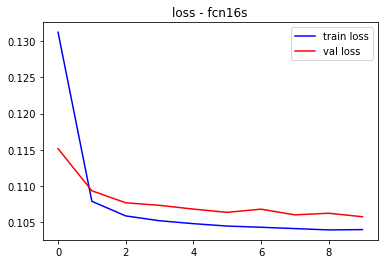

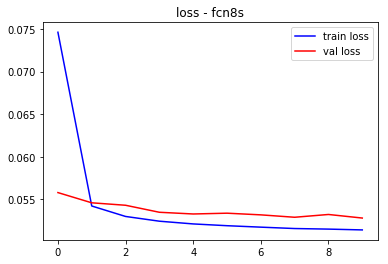

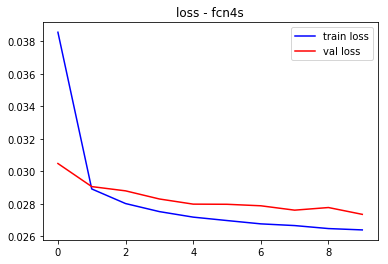

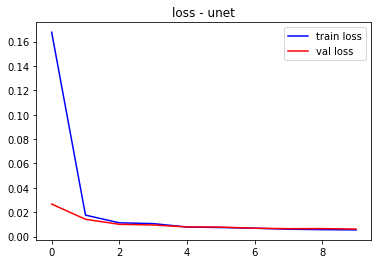

In [13]:
# Loss curve
def plot_loss(history, title=''):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(loss_train, 'b', label='train loss')
    ax.plot(loss_val, 'r', label='val loss')
    ax.legend()
    ax.set_title('loss - ' + title)
    plt.show()

for key, value in history.items():
    plot_loss(value, key)

In [14]:
predictions = {}
for name, model in models.items():
    print(name)
    pred = {}
    pred['test'] = model.predict(X_test, verbose=1)
    pred['val'] = model.predict(X_val, verbose=1)
    pred['train'] = model.predict(X_train, verbose=1)
    predictions[name] = pred 
    

fcn16s
44000/44000 [==============================] - 15s 333us/step
fcn8s
44000/44000 [==============================] - 13s 297us/step
fcn4s
44000/44000 [==============================] - 13s 294us/step
unet
44000/44000 [==============================] - 20s 462us/step


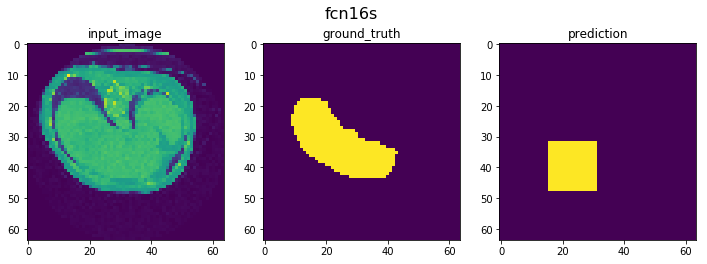

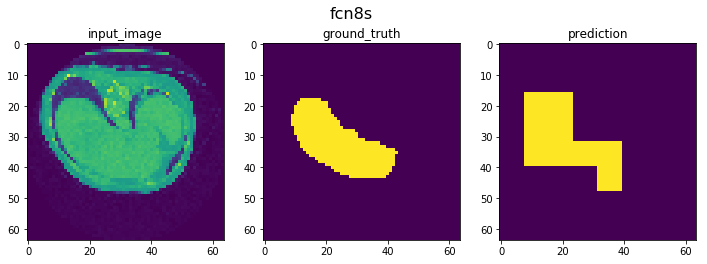

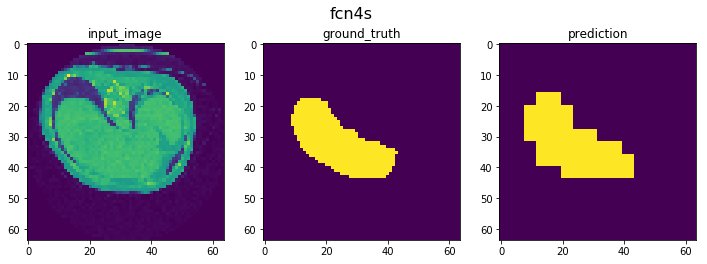

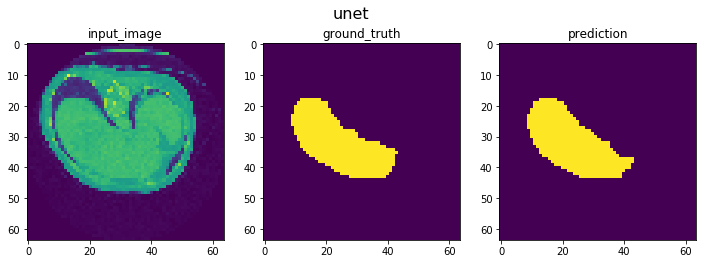

In [15]:
# Plotting the result images
def show_results(images, names, figure_title=''):
    fig = plt.figure(figsize=(12, 7))

    for idx, img in enumerate(images):
        ax = fig.add_subplot(1, 3, idx + 1)    
        ax.imshow(img)
        ax.set_title(names[idx])
    plt.suptitle(figure_title, fontsize=16)
    plt.subplots_adjust(top=1.3)
    plt.show()
    
idx = int(500)
img_in =  np.squeeze(X_test[idx,])
img_ans = np.argmax(Y_test[idx,], axis=2)
for key, value in predictions.items():
    pred_test = value['test']
    img_pred = np.argmax(pred_test[idx,], axis=2)
    show_results([img_in, img_ans, img_pred],
               ['input_image', 'ground_truth', 'prediction'], key)

In [16]:
# Calculating Dice coefficient
def calc_dice_coeff(labels, predicts):
    counts = predicts.shape[0]
    dice_score = np.zeros(shape = [counts,1])

    smooth = 1e-5
    for i in range(counts):
        img_truth = np.argmax(labels[i,], axis=2)
        img_pred = np.argmax(predicts[i,], axis=2)
        sum_truth = np.sum(img_truth)
        sum_pred = np.sum(img_pred)
        
        isct = np.sum(img_truth * img_pred)
        dice_score[i] = 2*isct / (sum_truth + sum_pred + smooth)

    avg_dice_score = np.sum(dice_score) / np.count_nonzero(dice_score) * 100
#     print("Dice coefficient: %.2f %%" % avg_dice_score)
    return avg_dice_score

def calc_score(model):

#     return train_score, val_score, test_score
    return test_score

input_list = [X_train, X_val, X_test]
label_list = [Y_train, Y_val, Y_test]
pred_key_list = ['train', 'val', 'test']

for name, model in models.items():
    print('{} model'.format(name))
    for i, value in enumerate(pred_key_list):
        print('  {} set'.format(value))
        score = model.evaluate(input_list[i], label_list[i], verbose=0)
        print('    score - loss : {}, dice coeff : {}'.format(score[0], score[1]))
        dice_coeff = calc_dice_coeff(label_list[i], predictions[name][value])
        print("    averaged dice coeff: %.2f %%" % dice_coeff)

fcn16s model
  train set
    score - loss : 0.2827032685198567, dice coeff : 0.9742540782581676
    averaged dice coeff: 40.43 %
  val set
    score - loss : 0.2897611432063931, dice coeff : 0.9738193885431934
    averaged dice coeff: 39.64 %
  test set
    score - loss : 0.3254242631091682, dice coeff : 0.9795690099369012
    averaged dice coeff: 41.66 %
fcn8s model
  train set
    score - loss : 0.07248488567634062, dice coeff : 0.9878429121537642
    averaged dice coeff: 70.53 %
  val set
    score - loss : 0.07518354636550142, dice coeff : 0.9876183612556975
    averaged dice coeff: 70.58 %
  test set
    score - loss : 0.11710675849319163, dice coeff : 0.9883500663515568
    averaged dice coeff: 70.08 %
fcn4s model
  train set
    score - loss : 0.026248007993806492, dice coeff : 0.9912466541637074
    averaged dice coeff: 77.84 %
  val set
    score - loss : 0.027355591958548368, dice coeff : 0.9911621518880852
    averaged dice coeff: 78.29 %
  test set
    score - loss : 0.0764